# Imports 

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
import yaml

# 1. Understanding the data 

Looking at the data we can see 2 types of breast cancer being either malignant or benign. furthermore we see 30 features per sample of breast cancer. 

# 2. Load the data

In [1]:
def get_config():
    with open("../config.yaml", 'r') as stream:
        config = yaml.safe_load(stream)
    return config

In [2]:
config = get_config()
df = pd.read_csv(config['breastcancer'])
df

# 3. Exploratory analysis

In [4]:
# there are no nan 
df.isnull().values.any()

False

## LDA 
To look which components maximizes the separation between malignant and benign we are going to use to train the model

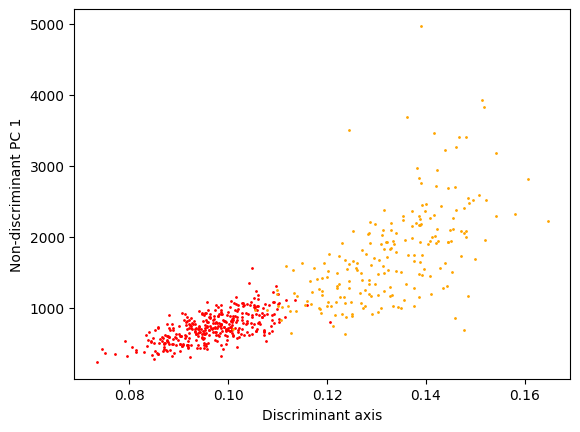

In [6]:
### step 1: devide your data
malignant = np.array(df[df.diagnosis == 'M'].values[:, 2:], dtype=float)
benign = np.array(df[df.diagnosis == 'B'].values[:, 2:], dtype=float)
### step2: calculated the mean and the covariance
mw = malignant.mean(axis=0)
mr = benign.mean(axis=0)

nw = malignant.shape[0]
nr = benign.shape[0]

Sw = np.cov(malignant.T)
Sr = np.cov(benign.T)
### step3: calculated the pooled covariance matrix
Sp = ((nr - 1) * Sr + (nw - 1) * Sw) / (nr + nw - 2)
### step4: project the data onto the discriminant axis
a = np.linalg.inv(Sp) @ (mw - mr)
a /= np.sqrt((a ** 2).sum())

tw = malignant @ a
tr = benign @ a

### step5: deflate both groups, combine and plot the data

Ew = malignant - tw[:, None] * a[None, :]
Er = benign - tr[:, None] * a[None, :]

X = np.concatenate((Ew, Er), axis=0)
S = np.cov(X.T)
vals, vecs = np.linalg.eig(S)
order = vals.argsort()[::-1]
vecs = vecs[:, order]
vals = vals[order]
Tw = malignant @ vecs
Tr = benign @ vecs


plt.scatter(tr, Tr[:, 0], s=1, c="red")
plt.scatter(tw, Tw[:, 0], s=1, c="orange")
plt.xlabel("Discriminant axis")
plt.ylabel("Non-discriminant PC 1")  
plt.show()

In [7]:
separation = [i/sum(vals)*100 for i in vals]
# the first component has 98% of the separation between the two groups
print(separation[:5])
# the first feature is the component that has 98% of the separation
print(order[:5])

[98.20446717546164, 1.6176489875553746, 0.15575107362089868, 0.012093183393653905, 0.008827244953170887]
[0 1 2 3 4]


# 4. Modeling (cross-validation and training)

In [8]:
X = np.array(df.values[:, 2], dtype=float)
X = np.reshape(X, (569,1))
y = df.values[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

In [10]:
dummy = DummyClassifier(random_state=42)
params = {
    'strategy': ['most_frequent', 'prior', 'stratified', 'uniform', 'constant']
}
dummy_grid = GridSearchCV(dummy, params, verbose=1)
best_dummy = dummy_grid.fit(X_test, y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/dummy.py", line 196, in fit
    raise ValueError(
ValueError: Constant target value has to be specified when the constant strategy is used.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_

# 5. Evaluation
a confussion matrix helps to see how well the models predict a certain class. In the last confusion matrices below the 0 and 1 on both axis means benign and malignant respectively. 



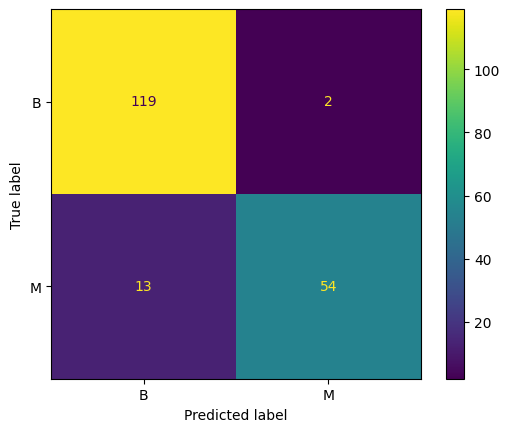

In [11]:
ConfusionMatrixDisplay.from_estimator(ada, X_test, y_test)

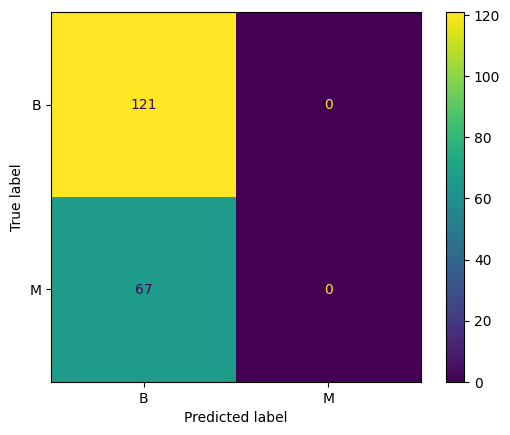

In [12]:
ConfusionMatrixDisplay.from_estimator(best_dummy, X_test, y_test)

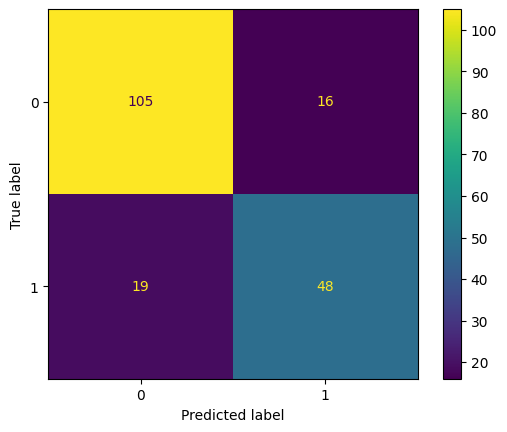

In [13]:
for index, value in enumerate(y):
    if value == 'M':
        y[index] = 1
    if value == 'B':
        y[index] = 0
y = np.array(y, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
XGBoost = XGBClassifier()
XGBoost.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(XGBoost, X_test, y_test)